## 3.2 Interest Rate Simulation under fBm

#### 3.2.1 Vasicek and CIR model

Simulation w.r.t. fBm-Driven Vasicek and CIR Model: Impact of Hurst Parameter

In [3]:
from utils import *

In [11]:
# === fBm Simulator using Davies-Harte method ===
class FBMSimulator:
    def __init__(self, n, T, H):
        self.n = n
        self.T = T
        self.H = H
        self.dt = T / n

    def generate_fbm_path(self, seed=None):
        if seed is not None:
            np.random.seed(seed)
        n = self.n
        H = self.H
        r = np.zeros(2 * n)
        for k in range(2 * n):
            j = k if k <= n else 2 * n - k
            r[k] = 0.5 * (np.abs(j + 1)**(2*H) + np.abs(j - 1)**(2*H) - 2 * np.abs(j)**(2*H))
        r[0] = 1.0
        eigenvalues = np.real(fft(r))
        eigenvalues = np.maximum(eigenvalues, 0)
        Z = np.zeros(2 * n, dtype=complex)
        Z[0] = np.sqrt(eigenvalues[0]) * np.random.randn()
        if n % 2 == 0:
            Z[n] = np.sqrt(eigenvalues[n]) * np.random.randn()
        for k in range(1, n):
            real = np.random.randn()
            imag = np.random.randn()
            Z[k] = np.sqrt(eigenvalues[k] / 2) * (real + 1j * imag)
            Z[2*n - k] = np.sqrt(eigenvalues[k] / 2) * (real - 1j * imag)
        Y = ifft(Z)
        fbm_path = np.real(Y[:n+1])
        fbm_path -= fbm_path[0]
        return fbm_path

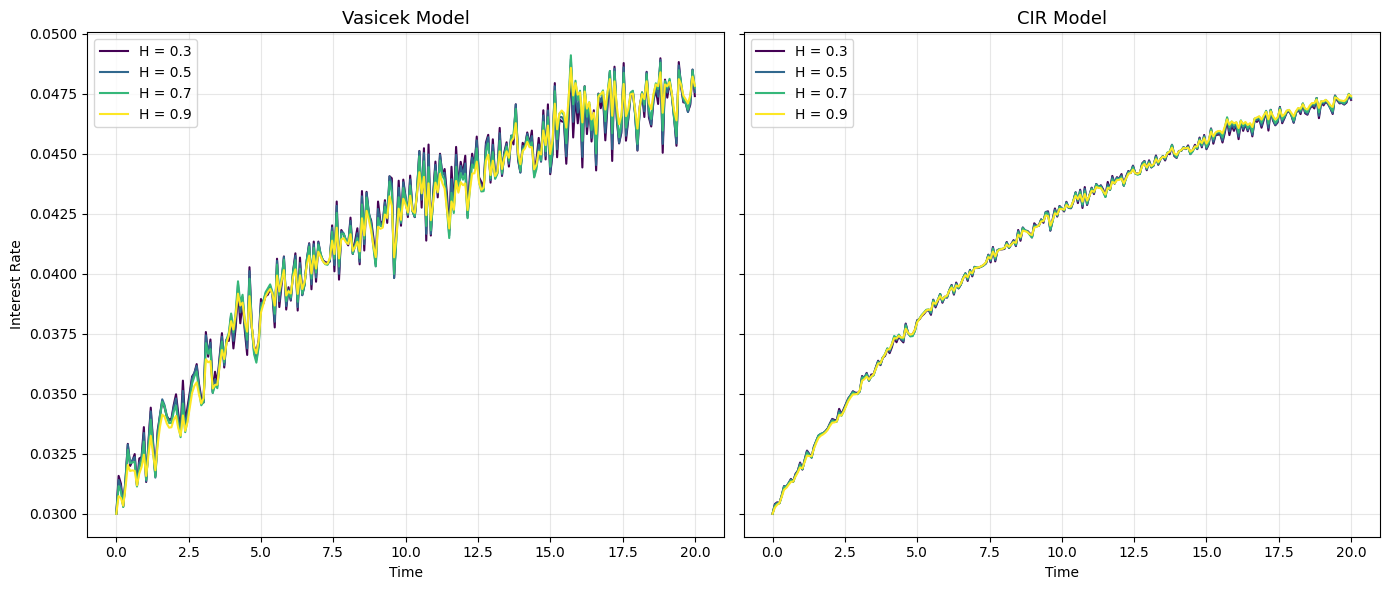

In [12]:
# === Vasicek Model Simulator ===
class VasicekModel:
    def __init__(self, alpha=0.1, mu=0.05, sigma=0.02, r0=0.03):
        self.alpha = alpha
        self.mu = mu
        self.sigma = sigma
        self.r0 = r0

    def simulate(self, fbm_path, dt):
        n = len(fbm_path) - 1
        r = np.zeros(n + 1)
        r[0] = self.r0
        for i in range(1, n + 1):
            dBH = fbm_path[i] - fbm_path[i-1]
            dr = self.alpha * (self.mu - r[i-1]) * dt + self.sigma * dBH
            r[i] = r[i-1] + dr
        return r

# === CIR Model Simulator ===
class CIRModel:
    def __init__(self, alpha=0.1, mu=0.05, sigma=0.02, r0=0.03):
        self.alpha = alpha
        self.mu = mu
        self.sigma = sigma
        self.r0 = r0

    def simulate(self, fbm_path, dt):
        n = len(fbm_path) - 1
        r = np.zeros(n + 1)
        r[0] = self.r0
        for i in range(1, n + 1):
            dBH = fbm_path[i] - fbm_path[i-1]
            sqrt_r = np.sqrt(np.maximum(r[i-1], 1e-10))
            dr = self.alpha * (self.mu - r[i-1]) * dt + self.sigma * sqrt_r * dBH
            r[i] = max(r[i-1] + dr, 1e-10)
        return r

# === Combined plotting function ===
def plot_vasicek_cir_comparison(H_values, n=252, T=20.0, seed=2024):

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

    colors = plt.cm.viridis(np.linspace(0, 1, len(H_values)))

    for idx, model_class in enumerate([VasicekModel, CIRModel]):
        ax = axes[idx]
        for i, H in enumerate(H_values):
            fbm_sim = FBMSimulator(n, T, H)
            fbm_path = fbm_sim.generate_fbm_path(seed=seed)
            t = np.linspace(0, T, n+1)
            dt = T / n
            model = model_class()
            r_path = model.simulate(fbm_path, dt)
            ax.plot(t, r_path, label=f'H = {H}', color=colors[i], linewidth=1.5)

        ax.set_title('Vasicek Model' if idx == 0 else 'CIR Model', fontsize=13)
        ax.set_xlabel('Time')
        ax.grid(True, alpha=0.3)
        if idx == 0:
            ax.set_ylabel('Interest Rate')
        ax.legend(fontsize=10)

    plt.tight_layout()
    return fig

# Execute and show the plot
H_values = [0.3, 0.5, 0.7, 0.9]
fig = plot_vasicek_cir_comparison(H_values)
plt.show()


Simulation w.r.t. fBm-Driven Vasicek and CIR Model: Impact of Mean-Reversion Speed $\alpha$

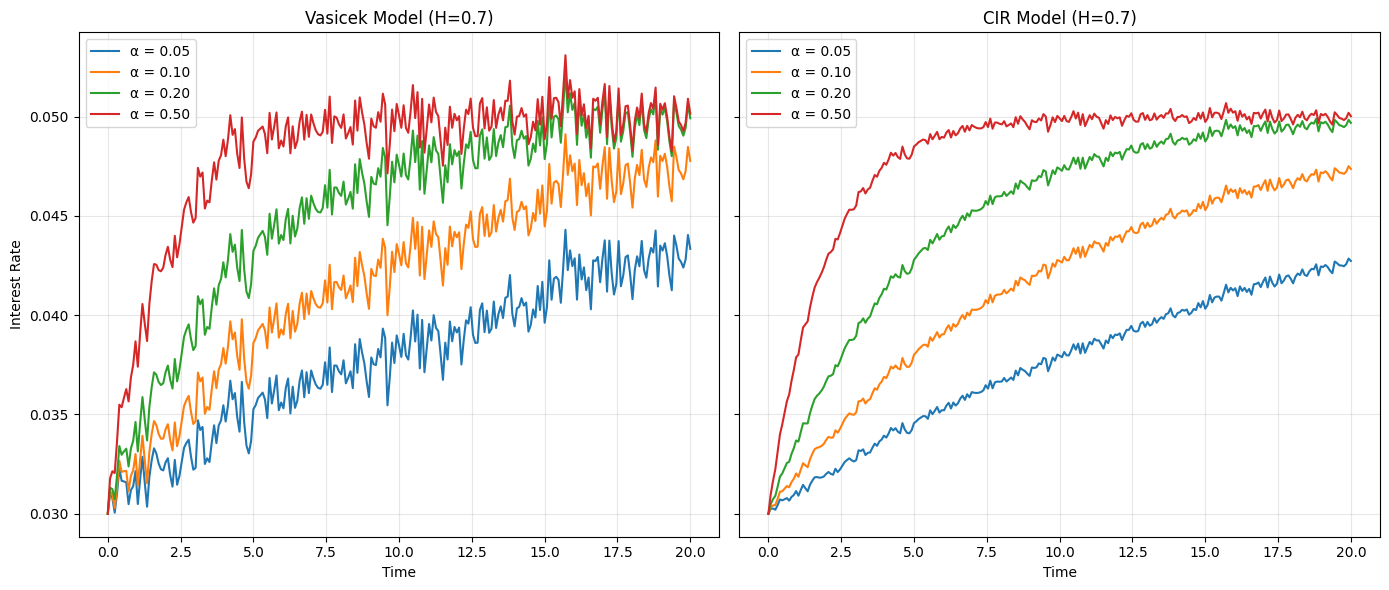

In [13]:
# === Vasicek Model ===
class VasicekModel:
    def __init__(self, alpha=0.1, mu=0.05, sigma=0.02, r0=0.03):
        self.alpha = alpha
        self.mu = mu
        self.sigma = sigma
        self.r0 = r0

    def simulate(self, fbm_path, dt):
        n = len(fbm_path) - 1
        r = np.zeros(n + 1)
        r[0] = self.r0
        for i in range(1, n + 1):
            dBH = fbm_path[i] - fbm_path[i-1]
            dr = self.alpha * (self.mu - r[i-1]) * dt + self.sigma * dBH
            r[i] = r[i-1] + dr
        return r

# === CIR Model ===
class CIRModel:
    def __init__(self, alpha=0.1, mu=0.05, sigma=0.02, r0=0.03):
        self.alpha = alpha
        self.mu = mu
        self.sigma = sigma
        self.r0 = r0

    def simulate(self, fbm_path, dt):
        n = len(fbm_path) - 1
        r = np.zeros(n + 1)
        r[0] = self.r0
        for i in range(1, n + 1):
            dBH = fbm_path[i] - fbm_path[i-1]
            sqrt_r = np.sqrt(np.maximum(r[i-1], 1e-10))
            dr = self.alpha * (self.mu - r[i-1]) * dt + self.sigma * sqrt_r * dBH
            r[i] = max(r[i-1] + dr, 1e-10)
        return r

# === Simulation Function ===
def simulate_model_paths(model_class, alpha_values, H, n=252, T=20.0, seed=2024):
    t = np.linspace(0, T, n+1)
    dt = T / n
    fbm_sim = FBMSimulator(n, T, H)
    fbm_path = fbm_sim.generate_fbm_path(seed=seed)
    
    paths = {}
    for alpha in alpha_values:
        model = model_class(alpha=alpha, mu=0.05, sigma=0.02, r0=0.03)
        r_path = model.simulate(fbm_path, dt)
        paths[alpha] = r_path
    return t, paths

# === Plotting in 1 row 2 columns ===
alpha_values = [0.05, 0.1, 0.2, 0.5]
H = 0.7

t, vasicek_paths = simulate_model_paths(VasicekModel, alpha_values, H=H)
t, cir_paths = simulate_model_paths(CIRModel, alpha_values, H=H)

fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Vasicek subplot
for alpha, r_path in vasicek_paths.items():
    axs[0].plot(t, r_path, label=f'α = {alpha:.2f}', linewidth=1.5)
axs[0].set_title(f'Vasicek Model (H={H})')
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Interest Rate")
axs[0].legend()
axs[0].grid(True, alpha=0.3)

# CIR subplot
for alpha, r_path in cir_paths.items():
    axs[1].plot(t, r_path, label=f'α = {alpha:.2f}', linewidth=1.5)
axs[1].set_title(f'CIR Model (H={H})')
axs[1].set_xlabel("Time")
axs[1].legend()
axs[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Simulation w.r.t. fBm-Driven Vasicek and CIR Model: Impact of Volatility $\sigma$

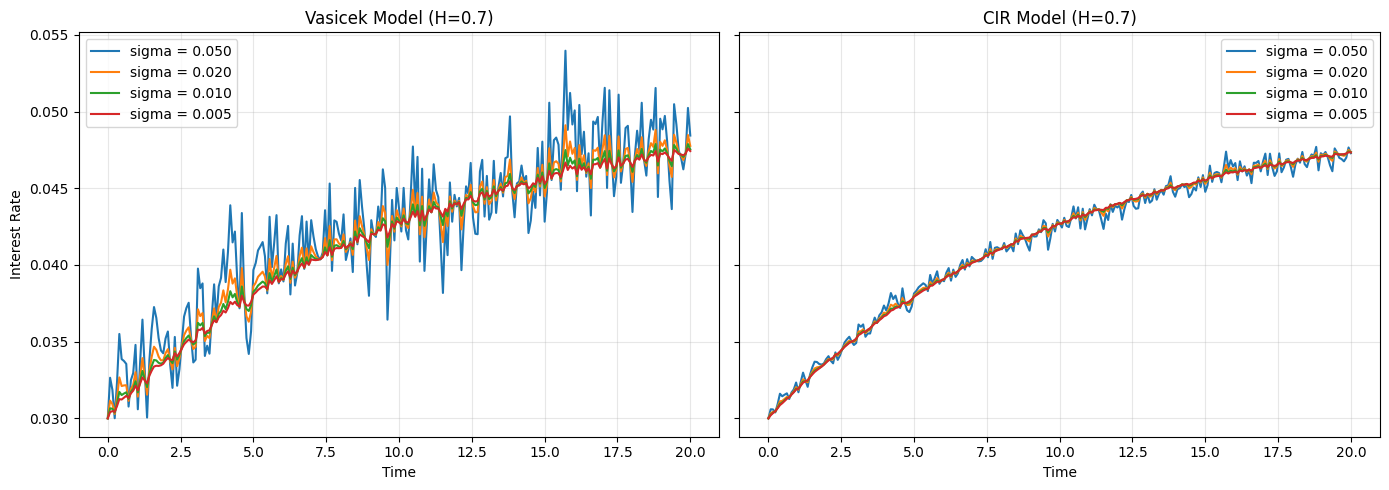

In [14]:
# === Vasicek Model ===
class VasicekModel:
    def __init__(self, alpha=0.1, mu=0.05, sigma=0.02, r0=0.03):
        self.alpha = alpha
        self.mu = mu
        self.sigma = sigma
        self.r0 = r0

    def simulate(self, fbm_path, dt):
        n = len(fbm_path) - 1
        r = np.zeros(n + 1)
        r[0] = self.r0
        for i in range(1, n + 1):
            dBH = fbm_path[i] - fbm_path[i-1]
            dr = self.alpha * (self.mu - r[i-1]) * dt + self.sigma * dBH
            r[i] = r[i-1] + dr
        return r

# === CIR Model ===
class CIRModel:
    def __init__(self, alpha=0.1, mu=0.05, sigma=0.02, r0=0.03):
        self.alpha = alpha
        self.mu = mu
        self.sigma = sigma
        self.r0 = r0

    def simulate(self, fbm_path, dt):
        n = len(fbm_path) - 1
        r = np.zeros(n + 1)
        r[0] = self.r0
        for i in range(1, n + 1):
            dBH = fbm_path[i] - fbm_path[i-1]
            sqrt_r = np.sqrt(np.maximum(r[i-1], 1e-10))
            dr = self.alpha * (self.mu - r[i-1]) * dt + self.sigma * sqrt_r * dBH
            r[i] = max(r[i-1] + dr, 1e-10)
        return r

# === Simulation Function: varying sigma ===
def simulate_model_paths(model_class, sigma_values, H, n=252, T=20.0, seed=2024):
    t = np.linspace(0, T, n+1)
    dt = T / n
    fbm_sim = FBMSimulator(n, T, H)
    fbm_path = fbm_sim.generate_fbm_path(seed=seed)

    paths = {}
    for sigma in sigma_values:
        model = model_class(alpha=0.1, mu=0.05, sigma=sigma, r0=0.03)
        r_path = model.simulate(fbm_path, dt)
        paths[sigma] = r_path
    return t, paths

# === Plotting Function with 1x2 subplot ===
def plot_paths_side_by_side(t, vasicek_paths, cir_paths, H):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

    for sigma, r_path in vasicek_paths.items():
        axes[0].plot(t, r_path, label=f'sigma = {sigma:.3f}', linewidth=1.5)
    axes[0].set_title(f'Vasicek Model (H={H})')
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Interest Rate')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    for sigma, r_path in cir_paths.items():
        axes[1].plot(t, r_path, label=f'sigma = {sigma:.3f}', linewidth=1.5)
    axes[1].set_title(f'CIR Model (H={H})')
    axes[1].set_xlabel('Time')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# === Run the simulations and generate side-by-side plot ===
sigma_values = [0.05, 0.02, 0.01, 0.005]
H = 0.7

t, vasicek_paths = simulate_model_paths(VasicekModel, sigma_values, H=H)
t, cir_paths = simulate_model_paths(CIRModel, sigma_values, H=H)
plot_paths_side_by_side(t, vasicek_paths, cir_paths, H)


Simulation w.r.t. fBm-Driven Vasicek and CIR Model: Impact of Long-term Mean $\mu$

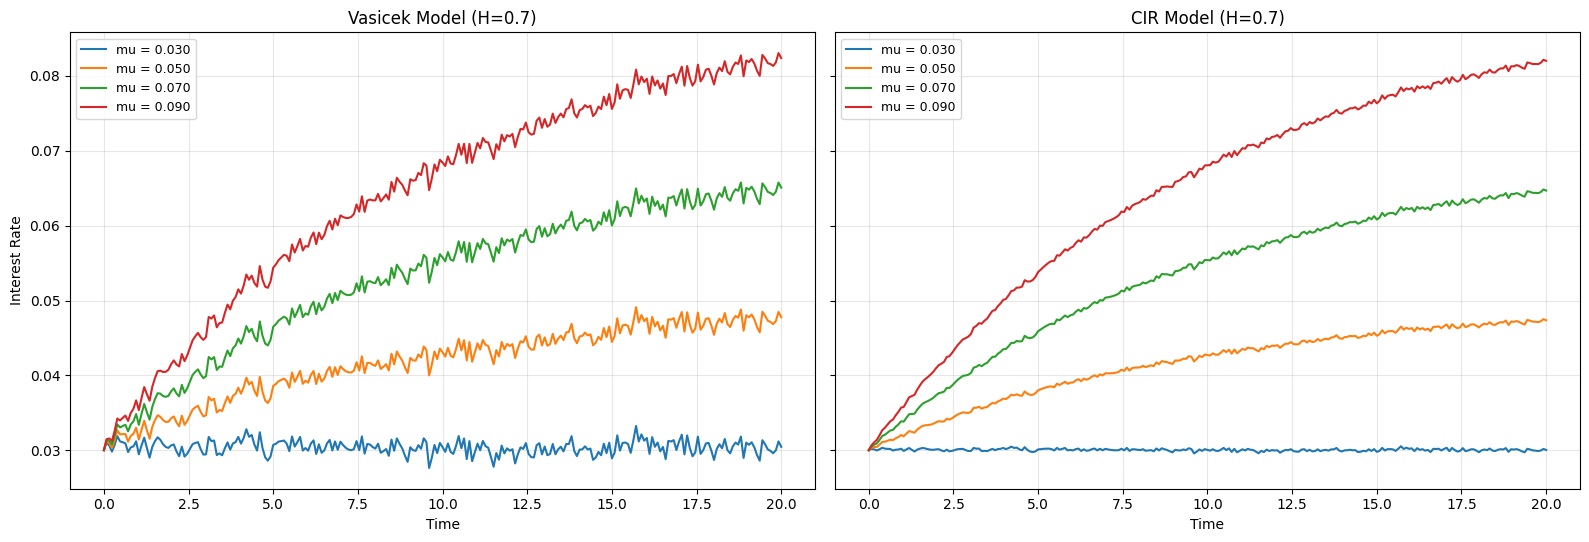

In [15]:
# === Vasicek Model ===
class VasicekModel:
    def __init__(self, alpha=0.1, mu=0.05, sigma=0.02, r0=0.03):
        self.alpha = alpha
        self.mu = mu
        self.sigma = sigma
        self.r0 = r0

    def simulate(self, fbm_path, dt):
        n = len(fbm_path) - 1
        r = np.zeros(n + 1)
        r[0] = self.r0
        for i in range(1, n + 1):
            dBH = fbm_path[i] - fbm_path[i-1]
            dr = self.alpha * (self.mu - r[i-1]) * dt + self.sigma * dBH
            r[i] = r[i-1] + dr
        return r

# === CIR Model ===
class CIRModel:
    def __init__(self, alpha=0.1, mu=0.05, sigma=0.02, r0=0.03):
        self.alpha = alpha
        self.mu = mu
        self.sigma = sigma
        self.r0 = r0

    def simulate(self, fbm_path, dt):
        n = len(fbm_path) - 1
        r = np.zeros(n + 1)
        r[0] = self.r0
        for i in range(1, n + 1):
            dBH = fbm_path[i] - fbm_path[i-1]
            sqrt_r = np.sqrt(np.maximum(r[i-1], 1e-10))
            dr = self.alpha * (self.mu - r[i-1]) * dt + self.sigma * sqrt_r * dBH
            r[i] = max(r[i-1] + dr, 1e-10)
        return r

# === Simulation Function: varying mu ===
def simulate_model_paths(model_class, mu_values, H, n=252, T=20.0, seed=2024):
    t = np.linspace(0, T, n+1)
    dt = T / n
    fbm_sim = FBMSimulator(n, T, H)
    fbm_path = fbm_sim.generate_fbm_path(seed=seed)

    paths = {}
    for mu in mu_values:
        model = model_class(alpha=0.1, mu=mu, sigma=0.02, r0=0.03)
        r_path = model.simulate(fbm_path, dt)
        paths[mu] = r_path
    return t, paths

# === Dual-panel Plotting Function ===
def plot_dual_panel(t, paths1, paths2, model1_name, model2_name, param_label, H, filename=None):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    for ax, paths, title in zip(axes, [paths1, paths2], [model1_name, model2_name]):
        for param, r_path in paths.items():
            ax.plot(t, r_path, label=f'{param_label} = {param:.3f}', linewidth=1.5)
        ax.set_xlabel("Time")
        ax.set_title(f"{title} Model (H={H})")
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=9)

    axes[0].set_ylabel("Interest Rate")
    # plt.suptitle(f"Impact of {param_label} on fBm-driven Interest Rate Models", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    if filename:
        plt.savefig(filename, dpi=300)
    plt.show()

# === Main Execution ===
mu_values = [0.03, 0.05, 0.07, 0.09]
H = 0.7

# Vasicek
t, vasicek_paths = simulate_model_paths(VasicekModel, mu_values, H=H)

# CIR
t, cir_paths = simulate_model_paths(CIRModel, mu_values, H=H)

# Plot dual-panel comparison
plot_dual_panel(t, vasicek_paths, cir_paths, "Vasicek", "CIR", "mu", H=H)


#### 3.2.2 Hull-White model: Drift Function Structure Analysis

Simulation w.r.t. fBm-Driven Hull-White Model with different drift functions

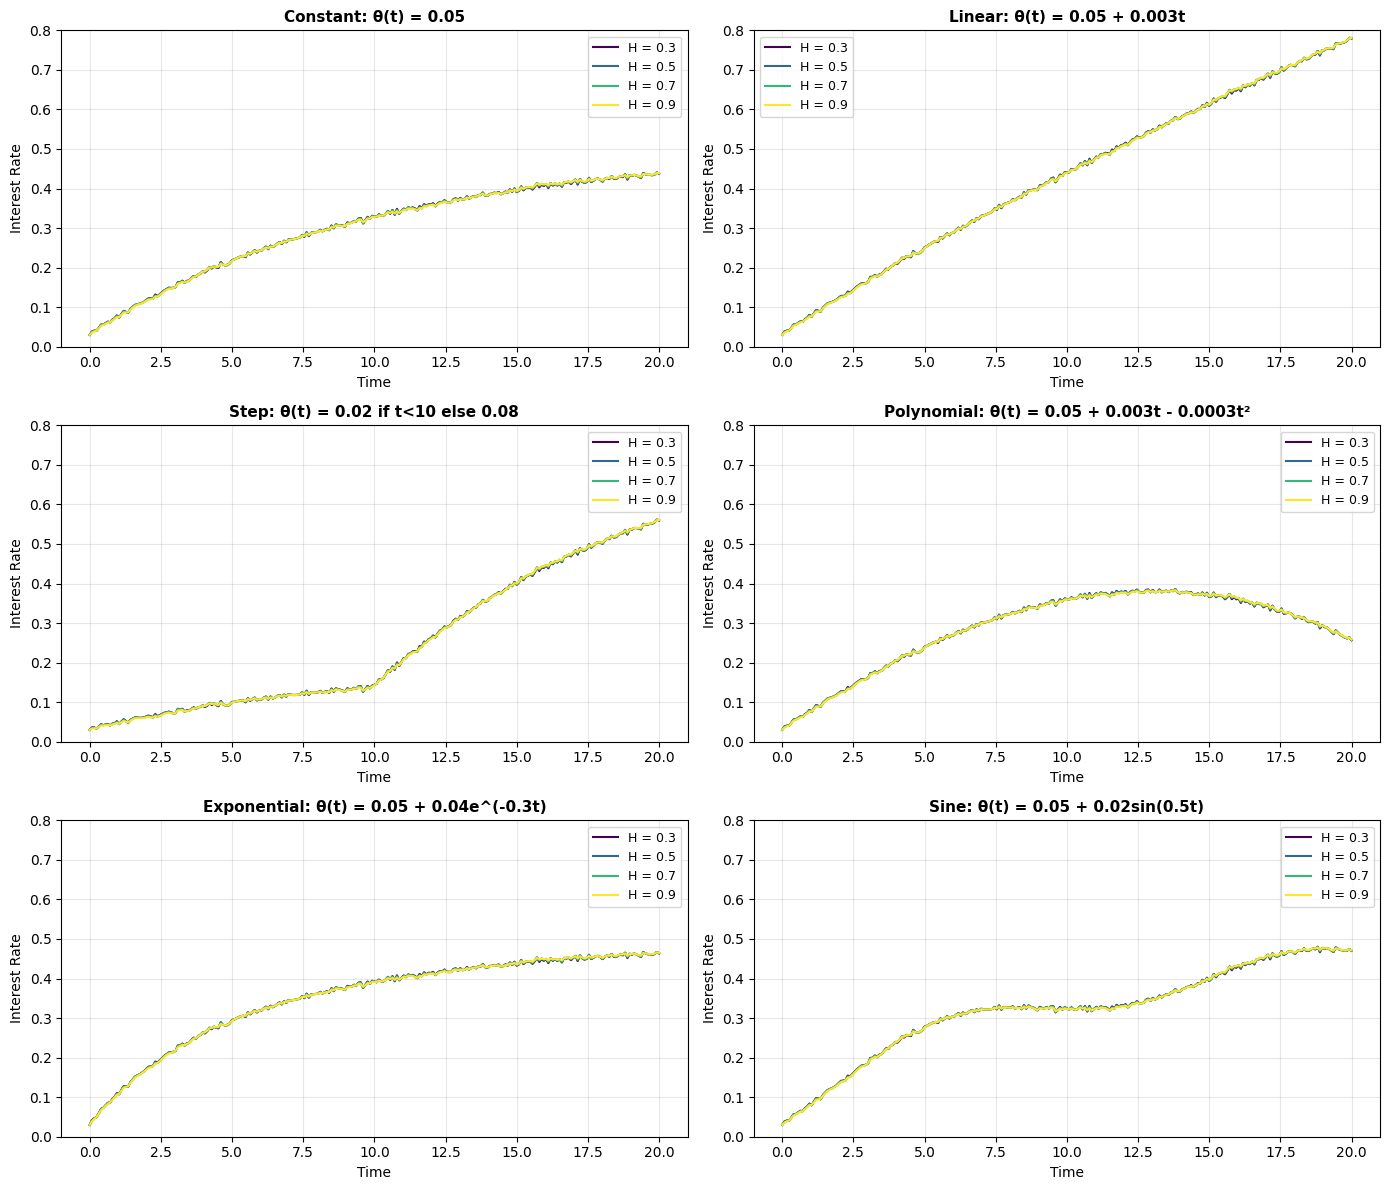

In [22]:
# === Hull-White Model Simulator ===
class HullWhiteModel:
    def __init__(self, alpha=0.1, sigma=0.02, r0=0.03, theta_func=None):
        self.alpha = alpha
        self.sigma = sigma
        self.r0 = r0
        self.theta_func = theta_func if theta_func is not None else (lambda t: 0.05)

    def simulate(self, fbm_path, dt):
        n = len(fbm_path) - 1
        r = np.zeros(n + 1)
        r[0] = self.r0
        for i in range(1, n + 1):
            t = i * dt
            dBH = fbm_path[i] - fbm_path[i - 1]
            theta_t = self.theta_func(t)
            dr = (theta_t - self.alpha * r[i - 1]) * dt + self.sigma * dBH / np.sqrt(dt)
            r[i] = r[i - 1] + dr
        return r

# === Simulation ===
def simulate_fbm_hullwhite(H=0.5, n=252, T=20.0, seed=2024, theta_func=None):
    fbm_sim = FBMSimulator(n, T, H)
    fbm_path = fbm_sim.generate_fbm_path(seed=seed)
    t = np.linspace(0, T, n + 1)
    dt = T / n
    hullwhite = HullWhiteModel(theta_func=theta_func)
    r_path = hullwhite.simulate(fbm_path, dt)
    return t, r_path

# === Theta functions ===
def theta_constant(t): return 0.05
def theta_linear(t): return 0.05 + 0.003 * t
def theta_step(t): return 0.02 if t < 10 else 0.08
def theta_polynomial(t): return 0.05 + 0.003*t - 0.0003*t**2
def theta_exponential(t): return 0.05 + 0.04 * np.exp(-0.3 * t)
def theta_sine(t): return 0.05 + 0.02 * np.sin(0.5 * t)

# === Plot Function ===
def plot_six_theta_functions(H_values=[0.3, 0.5, 0.7, 0.9], n=252, T=20.0, seed=2024):
    theta_functions = [
        (theta_constant, "Constant: θ(t) = 0.05"),
        (theta_linear, "Linear: θ(t) = 0.05 + 0.003t"),
        (theta_step, "Step: θ(t) = 0.02 if t<10 else 0.08"),
        (theta_polynomial, "Polynomial: θ(t) = 0.05 + 0.003t - 0.0003t²"),
        (theta_exponential, "Exponential: θ(t) = 0.05 + 0.04e^(-0.3t)"),
        (theta_sine, "Sine: θ(t) = 0.05 + 0.02sin(0.5t)")
    ]

    fig, axes = plt.subplots(3, 2, figsize=(14, 12))
    axes = axes.flatten()
    colors = plt.cm.viridis(np.linspace(0, 1, len(H_values)))

    for idx, (theta_func, theta_name) in enumerate(theta_functions):
        ax = axes[idx]
        for i, H in enumerate(H_values):
            t, r_path = simulate_fbm_hullwhite(H=H, n=n, T=T, seed=seed, theta_func=theta_func)
            ax.plot(t, r_path, label=f'H = {H}', color=colors[i], linewidth=1.5)
        ax.set_title(theta_name, fontsize=11, fontweight='bold')
        ax.set_xlabel('Time', fontsize=10)
        ax.set_ylabel('Interest Rate', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=9)
        ax.set_ylim(0, 0.8)

    plt.tight_layout()
    return fig

# Plot and show the 6-panel figure
fig = plot_six_theta_functions()


Simulation w.r.t. fBm-Driven Hull-White Model with Mean-Reverting Drift

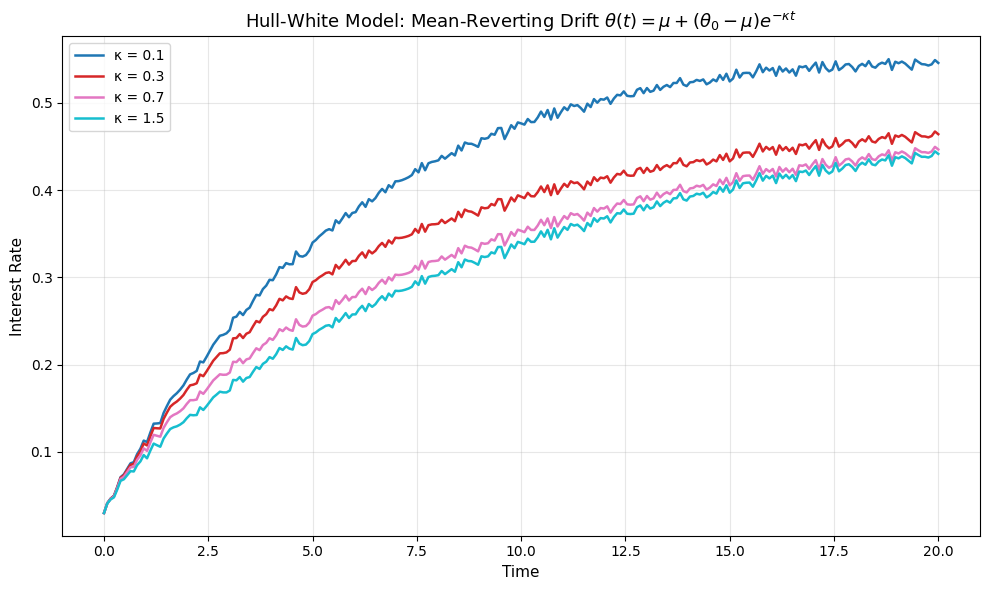

In [23]:
# === Mean-Reverting Drift Function Generator ===
def theta_mean_reverting(kappa, mu=0.05, theta0=0.09):
    return lambda t: mu + (theta0 - mu) * np.exp(-kappa * t)

# === Plotting function for different kappa ===
def plot_mean_reverting_drift(kappa_values=[0.1, 0.3, 0.7, 1.5], H=0.5, n=252, T=20.0, seed=2024):
    plt.figure(figsize=(10, 6))
    colors = plt.cm.tab10(np.linspace(0, 1, len(kappa_values)))
    
    for i, kappa in enumerate(kappa_values):
        theta_func = theta_mean_reverting(kappa=kappa)
        t, r_path = simulate_fbm_hullwhite(H=H, n=n, T=T, seed=seed, theta_func=theta_func)
        plt.plot(t, r_path, label=f'κ = {kappa}', color=colors[i], linewidth=1.8)
    
    plt.title(r'Hull-White Model: Mean-Reverting Drift $\theta(t) = \mu + (\theta_0 - \mu)e^{-\kappa t}$', fontsize=13)
    plt.xlabel('Time', fontsize=11)
    plt.ylabel('Interest Rate', fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# === Example: Run just this single plot ===
if __name__ == "__main__":
    plot_mean_reverting_drift(kappa_values=[0.1, 0.3, 0.7, 1.5], H=0.5, seed=2024)

#### 3.3 Parameter Calibration: Hurst Parameter $H$